In [ ]:
#Import necessary packages
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [ ]:
!pip install kaggle 

In [ ]:
# read dataset from kaggle 

import os # python library used for making directory , removing or renaming or anything associated with directory 
os.environ['KAGGLE_USERNAME'] = "shapna" # username from the json file that downloded from kaggle 
os.environ['KAGGLE_KEY'] = "9ada8a216b71a0bbae8b0cc17b4cc3af"  #key from the json file 
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 #api copied from dog-cat data api in kaggle 


100% 5.19G/5.20G [02:49<00:00, 42.9MB/s]
100% 5.20G/5.20G [02:49<00:00, 33.0MB/s]


In [ ]:
# Upload data and unzip
from zipfile import ZipFile

file_name = "/content/skin-cancer-mnist-ham10000.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:

# 'HAM10000_metadata.csv' contains path of 'HAM10000_images_part_1' and 'HAM10000_images_part_2'  
main_df = pd.read_csv('/content/HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:

# check unique images 
print(f"The total patient ids are {main_df['lesion_id'].count()}, from those the unique ids are {main_df['lesion_id'].value_counts().shape[0]} ")

The total patient ids are 10015, from those the unique ids are 7470 


In [ ]:
# explore data labels 
columns = main_df.keys()
columns = list(columns)
print(columns)

['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


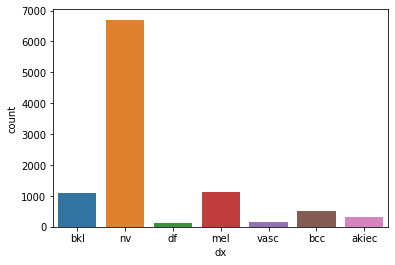

In [ ]:
# dx column contains the cancer types , we will count each type of cancer in graph representation

sns.countplot(main_df['dx'])

In [ ]:
# count each type of skin issues
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

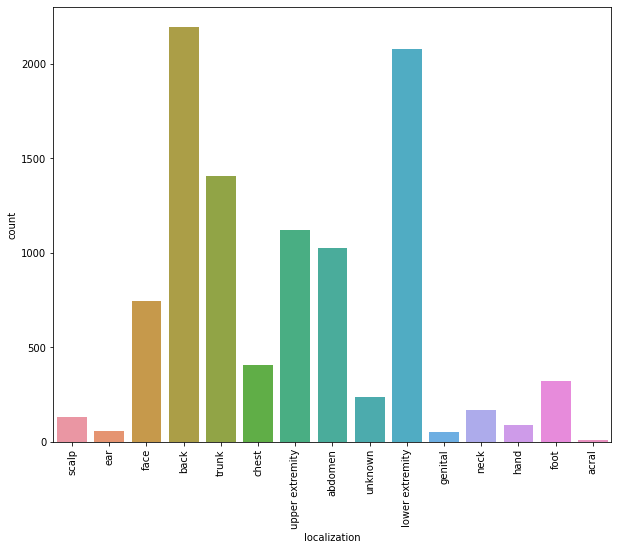

In [ ]:
# localization of skin cancer in body parts 
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

In [ ]:
# check null value 

main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [ ]:
#filling missing values using mean value 
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [ ]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

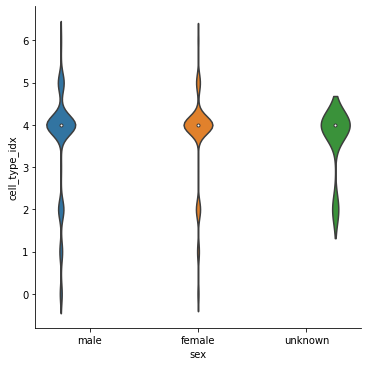

In [ ]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

In [ ]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [ ]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg


In [ ]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [ ]:
image_example.shape

(450, 600, 3)

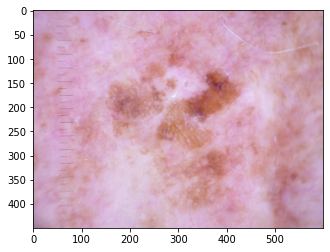

In [ ]:
plt.imshow(image_example)

The dimensions of the image are 450 pixels width and 600 pixels height, RGB color channel
The maximum pixel value is 255.0000 and the minimum is 43.0000
The mean value of the pixels is 184.3663 and the standard deviation is 28.7018


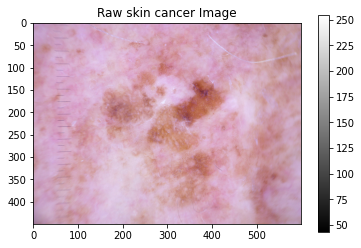

In [ ]:
# Get the first image that was listed in the train_df dataframe
plt.imshow(image_example, cmap='gray')
plt.colorbar()
plt.title('Raw skin cancer Image')
print(f"The dimensions of the image are {image_example.shape[0]} pixels width and {image_example.shape[1]} pixels height, RGB color channel")
print(f"The maximum pixel value is {image_example.max():.4f} and the minimum is {image_example.min():.4f}")
print(f"The mean value of the pixels is {image_example.mean():.4f} and the standard deviation is {image_example.std():.4f}")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

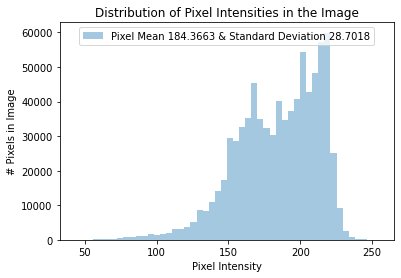

In [ ]:
# investigate pixel value distribution
# Plot a histogram of the distribution of the pixels
sns.distplot(image_example.ravel(), 
             label=f'Pixel Mean {np.mean(image_example):.4f} & Standard Deviation {np.std(image_example):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,120))))

In [ ]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0027419.jpg,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0026769.jpg,"[[[187, 127, 136], [190, 134, 146], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [24, 11, 20], [30, 16, 26], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,ham10000_images_part_2/ISIC_0031633.jpg,"[[[130, 88, 110], [142, 97, 120], [152, 107, 1..."


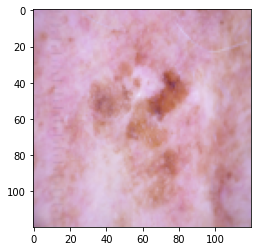

In [ ]:
plt.imshow(main_df['image'][0])

In [ ]:
main_df['image'][0].shape

(120, 120, 3)

In [ ]:
features=main_df.drop(columns=['cell_type_idx'],axis=1)
target=main_df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.02)


In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.02)


In [ ]:
print(x_train.shape)
print(x_test.shape)

(9617, 120, 120, 3)
(201, 120, 120, 3)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(120, 120, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 120, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120,120, 3))

In [ ]:
input_shape = (120, 120, 3)
num_classes = 7

In [ ]:
import tensorflow as tf

In [ ]:
from keras.applications.mobilenet import MobileNet

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential , Model

In [ ]:
import os
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout,MaxPooling2D,BatchNormalization,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score


In [ ]:
base_model = MobileNet(weights="imagenet", include_top=False , input_shape=(120, 120, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import Dropout , GlobalAveragePooling2D
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 60, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 60, 60, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 60, 60, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 60, 60, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 60, 60, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 60, 60, 32)        0     

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
from google.colab import drive

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epochs = 30
batch_size = 32

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
300/300 [==============================] - 103s 165ms/step - loss: 1.3333 - accuracy: 0.6292 - val_loss: 1.0035 - val_accuracy: 0.6447
Epoch 2/30
300/300 [==============================] - 46s 152ms/step - loss: 0.6801 - accuracy: 0.7684 - val_loss: 0.7746 - val_accuracy: 0.7462
Epoch 3/30
300/300 [==============================] - 46s 152ms/step - loss: 0.5439 - accuracy: 0.8126 - val_loss: 0.7903 - val_accuracy: 0.7259
Epoch 4/30
300/300 [==============================] - 45s 151ms/step - loss: 0.4984 - accuracy: 0.8236 - val_loss: 0.8812 - val_accuracy: 0.7259
Epoch 5/30
300/300 [==============================] - 45s 151ms/step - loss: 0.4506 - accuracy: 0.8359 - val_loss: 0.7335 - val_accuracy: 0.7614
Epoch 6/30
300/300 [==============================] - 45s 150ms/step - loss: 0.3999 - accuracy: 0.8580 - val_loss: 1.1933 - val_accuracy: 0.5888
Epoch 7/30
300/300 [==============================] - 46s 153ms/step - loss: 0.3788 - accuracy: 0.8636 - val_loss: 0.9501 - val_a

In [ ]:
filepath = "/content/drive/MyDrive/skin_cancer/models/effnet_modelB5.h5"



In [ ]:
new_model = tf.keras.models.load_model(filepath)

In [ ]:
model.save(filepath)

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
#convert the model 
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp581ji8dn/assets


In [ ]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [ ]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

In [ ]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE

In [ ]:
import tensorflow as tf

In [ ]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = export_dir

# Set the optimzations
converter.optimizations = # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = # YOUR CODE HERE

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

13329756